In [1]:
# Inline Model from Working Version-V3_reaper_midi error_drop_05_nosig_best.ipynb
# Updated to save as: Github Prep


In [2]:
import os
import numpy as np
import robert
import librosa
import numpy as np
import torch
from nnAudio import Spectrogram
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import sys

#github test comment 1


C:\Users\windo\anaconda3\envs\torch_new\lib\site-packages\nnAudio\Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


In [3]:
def print_gpu_info():
    """
    Prints information about the available GPUs.

    This function checks if any GPUs are available using PyTorch's cuda module.
    If available, it prints the number of GPUs and details of each GPU, including
    its name and total memory. If no GPUs are available, it prints a message
    stating that GPUs are not available.
    """
    if torch.cuda.is_available():
        print("GPU Information:")
        print("Number of GPUs available:", torch.cuda.device_count())
        for i in range(torch.cuda.device_count()):
            gpu_info = torch.cuda.get_device_properties(i)
            print(f"  GPU {i}: {gpu_info.name} (Memory: {gpu_info.total_memory / 1e9:.2f} GB)")
    else:
        print("GPU is not available.")

# Print the version of Python
print("Python Version:", sys.version)

# Print the version of PyTorch
print("PyTorch Version:", torch.__version__)

# Call the function to print GPU information
print_gpu_info()


Python Version: 3.10.9 | packaged by conda-forge | (main, Jan 11 2023, 15:15:40) [MSC v.1916 64 bit (AMD64)]
PyTorch Version: 1.12.1
GPU Information:
Number of GPUs available: 1
  GPU 0: NVIDIA GeForce RTX 3080 Laptop GPU (Memory: 8.59 GB)


In [4]:
#This works. Never Change! Only needs to be executed once per reaper_midi file.

def process_midi_file(input_file_path, output_file_path, width, note_space, sec, new_loop_time):
        
    """
    reaper_midi_loops.csv:
        The purpose of this code is to convert one long midi file into smaller (2.5s) indexed loops.
        Created by combining thousands of midi loops into a single file in Reaper and exporting midi data into a csv file.
        This code converts the resulting file into smaller loops (~2.5s) and stores in an indexed numpy array.
        
    Reads 'reaper_midi_loops.csv' and:
        Adds 2 extra colums: loop_time and loop_num
        Inserts 'gap' loops where space between notes > slice_ticks
        Rearranges the order of the columns --> Note: Using other versions may not reverse time/note
        Mulitply note by note_space; scale loop_time
        Truncates notes greater that x value of STFT (usually 832).
        'ticks' are the number of time intervals per beat. Usually 960 for midi.
        
    Args:
        input_file_path (str): The file path to the CSV file of MIDI notes to be processed.
        output_file_path (str): The file path where the processed MIDI array will be saved as a CSV file.
        width (int): The width of the spectrogram.
        note_space (int): The space between each note in the MIDI file.
        sec (int): The length of each time slice in seconds.

    Returns:
        tuple[np.ndarray, int]: A tuple containing the processed MIDI array as a numpy array and the number of slices.
    """
    
    import numpy as np
    midi_notes = np.genfromtxt(input_file_path, delimiter=',', dtype=int)

    # Read the CSV file into a numpy array
    midi_notes = midi_notes.astype(int)

    bpm = 120
    slice_ticks = sec * 960 * bpm/60
    print('ticks per slice: ', slice_ticks)
   
    # Add two additional columns to midi_notes
    midi_notes = np.concatenate((midi_notes, np.zeros((midi_notes.shape[0], 2), dtype=np.int32)), axis=1)

    # Loop through each row in midi_notes and add slice and offset columns
    for i, row in enumerate(midi_notes):
        slice_index = int(row[1]) // slice_ticks
        midi_notes[i, 3] = int(row[0]) // slice_ticks
        midi_notes[i, 4] = int((row[0]) - (midi_notes[i, 3] * slice_ticks))

        # find the last cell in the index column. Add 1 for 0-based
        num_slices = midi_notes[-1, 3] + 1

    # Insert gap arrays
    # Important: If there is a gap between MIDI notes that is longer than the loop time, it will corrupt the indexing.
    # This code inserts a blank loop to maintain the correct indexing, since the midi and audio need to align.
    
    for i in range(len(midi_notes) - 1):
        if midi_notes[i+1][3] - midi_notes[i][3] > 1:
            new_row = midi_notes[i].copy()
            new_row[1] = 0
            new_row[2] = 0
            new_row[3] += 1
            new_row[4] = 0

            midi_notes = np.insert(midi_notes, i+1, new_row, axis=0)
    
    # rearrange columns: note, loop_time, vel, loop, time
    midi_notes = midi_notes.take([1, 4, 2, 3, 0], axis=1)
        
    # Loop through each row in midi_notes and scale note and loop_time
    for i, row in enumerate(midi_notes):
        midi_notes[i, 1] = np.round((row[1]) * (width-1)/slice_ticks)
        midi_notes[i, 0] = int(row[0]) * note_space
    
    # midi_notes is a numpy array
    np.savetxt(output_file_path, midi_notes, delimiter=',', fmt='%d')
    
    # These functions create empty splices and then truncate 
    
    def create_empty_slice_list(num_slices):
        return [np.empty((0, 5), int) for _ in range(num_slices)]

    def split_into_slices(midi_notes, midi_np):
        for row in midi_notes:
            midi_np[row[3]] = np.vstack((midi_np[row[3]], row))
        return midi_np

    def truncate_loop_time(midi_array_list, new_loop_time):
        truncated_midi_array_list = []
        for arr in midi_array_list:
            new_midi_array_list = arr[arr[:, 1] < new_loop_time]
            truncated_midi_array_list.append(new_midi_array_list)
        return truncated_midi_array_list
    
    # Create empty slices for gaps in midi file
    midi_np_empty = create_empty_slice_list(num_slices)
    
    # Split into slices (np_arrays) based on the loop_num from reaper_midi
    midi_np_slices = split_into_slices(midi_notes, midi_np_empty)
 
    # Uncomment to see loop_num, non-scaled time columns
    midi_np_slices_3 = [np.delete(arr, [3, 4], axis=1) for arr in midi_np_slices]
    
    # Truncate the midi notes greater than x value to match STFT output truncation
    midi_np_truncated = truncate_loop_time(midi_np_slices_3, new_loop_time)

    return midi_np_truncated, num_slices

# Usage
#input_file_path = r"D:\Python\common\midi\reaper_midi_loop.csv"
#output_file_path = r"D:\Python\common\midi\reaper_midi_loop_processed.csv"
#list_of_midi_arrays, num_slices = process_midi_file(input_file_path, output_file_path, width=862, note_space=8, sec=2.5, new_loop_time=832)

#list_of_midi_arrays[0].shape, num_slices, list_of_midi_arrays[0]

In [28]:
# Create Y data for training
# Y Step 1
# Create list_of_midi_arrays
# Time-scales and truncates midi arrays.
# Inserts empty arrays if no midi data within loop_time
# Contains three columns: note, loop_time, vel
# Truncate time divisions from 862 -> 832 to match STFT width.

def get_list_of_midi_arrays(input_file_path, output_file_path, width=862, note_space=1, sec=2.5, new_loop_time=832):
    list_of_midi_arrays, num_slices = process_midi_file(input_file_path, output_file_path, 
                                                                width=width, note_space=note_space, sec=sec, new_loop_time=new_loop_time)
    return list_of_midi_arrays, num_slices

# Usage
input_file_path = r"midi\reaper_midi_GM.csv"
output_file_path = r"midi\reaper_GM_midi_processed.csv"
list_of_midi_arrays, num_slices = get_list_of_midi_arrays(input_file_path, output_file_path, width=862, note_space=1, sec=2.5, new_loop_time=832)

# Print the last array to confirm format, data, and number of arrays created
list_of_midi_arrays[0].shape, num_slices, list_of_midi_arrays[num_slices - 1]

ticks per slice:  4800.0


((3, 3),
 13680,
 array([[ 51,  87,  80],
        [ 38,  89,  97],
        [ 51, 175,  66],
        [ 51, 261,  65],
        [ 36, 344,  84],
        [ 51, 349,  72],
        [ 51, 437,  64],
        [ 51, 522,  68],
        [ 38, 604, 100],
        [ 51, 605,  77],
        [ 51, 693,  68],
        [ 36, 780,  89],
        [ 51, 781,  68]]))

In [6]:
# Y Step 2
# Insert midi data into (127, 832) np arrays. 
# 127: Range of midi note values. 832: number of time slices per loop.
# Create list of arrays: 'list_of_processed_midi'

def process_list_of_midi_arrays(list_of_midi_arrays):
    list_of_processed_midi = []

    for idx, midi_array in enumerate(list_of_midi_arrays):
        processed_midi = np.zeros((127, 832))

        for row in midi_array:
            drum_id = int(row[0])     # assuming row[0] contains the drum ID (0 to 126)
            time_slice_idx = int(row[1])  # assuming row[1] contains the time slice index (0 to 831)
            velocity = row[2]         # assuming row[2] contains the velocity

            processed_midi[drum_id, time_slice_idx] = velocity

        list_of_processed_midi.append(processed_midi)
    
    return list_of_processed_midi

list_of_processed_midi = process_list_of_midi_arrays(list_of_midi_arrays)
print(list_of_processed_midi[1].shape)

(127, 832)


In [7]:
# Dataset for X, Y.
# Data loader for training loop
# Creates audio and midi slices to feed to model

class AudioSliceDataset(Dataset):
    def __init__(self, audio_path, midi_data, slice_len_sec, sr=44100):
        self.audio, _ = librosa.load(audio_path, sr=sr)
        self.slice_len = int(slice_len_sec * sr)  # Length of slice in samples
        self.slices = self._slice_audio()
        self.midi_data = midi_data  # Processed MIDI data

    def _slice_audio(self):
        num_slices = len(self.audio) // self.slice_len
        return [self.audio[i * self.slice_len:(i + 1) * self.slice_len] for i in range(num_slices)]

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        #print("idx: ", idx)
        audio_slice = torch.from_numpy(self.slices[idx]).float()  # Removed .to(device)
        midi_slice = torch.from_numpy(self.midi_data[idx]).float()  # Removed .to(device)
        midi_slice /= 127
        return audio_slice, midi_slice


In [8]:
"""
DrumClassifier is a convolutional neural network for classifying drum sounds from audio data.

Steps:
    Input is a pytorch tensor of a 2.5s slice of a longer audio drum track (wav, mono).
    nnAudio converts the input into an STFT (short time fourier transform) - inline!
    This STFT (X) will be compared against the [127, 832] plot of the corresponding midi data (Y)
    
x1.shape:  torch.Size([1, 110250]) -> 44,100 samples/s * 2.5s
Output shape: torch.Size([1, 127, 832]) -> this is the grid for midi notes, rel timing, and velocity.

Details: 
Input: PyTorch tensor from a mono audio WAV file.
STFT Conversion: nnAudio is used for inline conversion to STFT.
Convolutional Layers: Three layers (conv1, conv2, conv3) for feature extraction.
Pooling and Dropout: Max pooling for dim reduction and dropout layers to prevent overfitting.
Batch Normalization: Included for stable and faster training.
Deconvolutional Layers: Upsample feature maps (deconv1, deconv2, deconv3) to match MIDI data dims.
Output Shape: Matches MIDI data plot size [127, 832].
Forward Pass: Includes STFT transformation and sequential processing through layers.
This structure leverages nnAudio for efficient audio processing and neural networks for classification.
"""

class DrumClassifier(nn.Module):
    def __init__(self):
        super(DrumClassifier, self).__init__()
        
        # Initialize the STFT layer using inline nnAudio
        self.spec_layer = Spectrogram.STFT(n_fft=2048, hop_length=128, win_length=2048, 
                                      trainable=True, window='hann', output_format='Magnitude')

        self.conv1 = nn.Conv1d(in_channels=1024, out_channels=512, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Dropout layers to prevent overfitting
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.5)
        
        # Batch normalization layers to speed up training
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.deconv1 = nn.ConvTranspose1d(128, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose1d(256, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose1d(512, 127, kernel_size=3, stride=2, padding=1, output_padding=1)
        #self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #print("x1.shape: ", x.shape)
        
        # Apply spectrogram to nnAudio input
        x = self.spec_layer(x)
        
        # truncate audio STFT to match torch.Size for convolution results
        x = x[:, :1024, :832]    
        #print("x2.shape: ", x.shape)
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        #x = self.sigmoid(x)
        return x


In [9]:
"""
Device Selection:Determines whether a GPU is available for computation; 
if not, it defaults to using the CPU. This choice significantly impacts the speed and 
efficiency of model training.

Model and Training Setup: Initializes the DrumClassifier model, sets up a loss 
function for training (Mean Squared Error), and configures an Adam optimizer with a 
defined learning rate, crucial for guiding the learning process of the model.

Adaptive Learning Rate: A scheduler is employed to adjust the learning rate based on 
the model's performance, optimizing training efficiency and effectiveness.

Data Preparation and Loading: The code processes audio data and corresponding MIDI 
information, then loads it into a DataLoader for batch processing. Essential 
for handling large datasets efficiently.

Data Handling and Splitting: The dataset is split into training and testing sets, 
ensuring a good balance for model evaluation. Separate data loaders are created for 
each, allowing distinct handling of training and testing phases.

"""

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split

# Set your device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Hyperparameters
batch_size = 16
num_epochs = 10
learning_rate = 1e-4

# Initialize the model, loss function, and optimizer
model = DrumClassifier().to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Initialize the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

audio_path = r"midi\reaper_GM_audio_1.wav"
list_of_processed_midi = process_list_of_midi_arrays(list_of_midi_arrays)
dataset = AudioSliceDataset(audio_path, list_of_processed_midi, slice_len_sec=2.5)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Get the first batch of data
first_batch = next(iter(dataloader))

# Extract the X and Y data
x_data, y_data = first_batch

# Move the data to the GPU (if available)
x_data = x_data.to(device)
y_data = y_data.to(device)

# Print the shape of the X and Y data
print("X shape:", x_data.shape)
print("Y shape:", y_data.shape)


# Calculate the lengths of the training and test sets (80/20 split)
train_len = int(len(dataset) * 0.8)
test_len = len(dataset) - train_len

# Split the dataset into training and test sets
train_set, test_set = random_split(dataset, [train_len, test_len])
print("train_len: ", train_len)

# Create data loaders for the training and test sets
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)


cuda
STFT kernels created, time used = 0.0695 seconds
X shape: torch.Size([32, 110250])
Y shape: torch.Size([32, 127, 832])
train_len:  10944


In [10]:
# Train the model
# Training loop with loss and accuracy tracking
# Train the model

import time  # Import the time module

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

clip_value = 0.5  # You can change this value depending on your needs


for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time for the epoch

    # Training
    model.train()
    epoch_train_loss = 0.0
    num_correct_train = 0
    num_samples_train = 0

    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        optimizer.step()

        epoch_train_loss += loss.item()

        # Calculate accuracy
        predicted = (outputs > 0.5).float()
        num_correct_train += (predicted == targets).sum().item()
        num_samples_train += targets.numel()

    avg_epoch_train_loss = epoch_train_loss / len(train_loader)
    epoch_train_accuracy = num_correct_train / num_samples_train

    train_losses.append(avg_epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Testing
    model.eval()
    epoch_test_loss = 0.0
    num_correct_test = 0
    num_samples_test = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, targets)
            epoch_test_loss += loss.item()

            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            num_correct_test += (predicted == targets).sum().item()
            num_samples_test += targets.numel()

    avg_epoch_test_loss = epoch_test_loss / len(test_loader)
    epoch_test_accuracy = num_correct_test / num_samples_test

    # Update the learning rate based on the validation loss
    scheduler.step(avg_epoch_test_loss)

    test_losses.append(avg_epoch_test_loss)
    test_accuracies.append(epoch_test_accuracy)

    end_time = time.time()  # Record the end time for the epoch
    epoch_time = end_time - start_time  # Calculate the time taken for the epoch in seconds

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_epoch_train_loss:.4e}, Train Accy: {epoch_train_accuracy:.4e}, Test Loss: {avg_epoch_test_loss:.4e}, Test Accy: {epoch_test_accuracy:.4e}, Time: {epoch_time:.2f} s")


Epoch [1/10], Train Loss: 9.2985e-05, Train Accy: 9.9983e-01, Test Loss: 6.4357e-05, Test Accy: 9.9983e-01, Time: 76.25 s
Epoch [2/10], Train Loss: 5.6234e-05, Train Accy: 9.9983e-01, Test Loss: 5.1499e-05, Test Accy: 9.9983e-01, Time: 66.30 s
Epoch [3/10], Train Loss: 4.8453e-05, Train Accy: 9.9983e-01, Test Loss: 4.6650e-05, Test Accy: 9.9983e-01, Time: 62.94 s
Epoch [4/10], Train Loss: 4.3479e-05, Train Accy: 9.9983e-01, Test Loss: 4.1298e-05, Test Accy: 9.9983e-01, Time: 62.29 s
Epoch [5/10], Train Loss: 3.8487e-05, Train Accy: 9.9983e-01, Test Loss: 3.6388e-05, Test Accy: 9.9983e-01, Time: 62.13 s
Epoch [6/10], Train Loss: 3.4121e-05, Train Accy: 9.9983e-01, Test Loss: 3.2515e-05, Test Accy: 9.9983e-01, Time: 61.75 s
Epoch [7/10], Train Loss: 3.0221e-05, Train Accy: 9.9983e-01, Test Loss: 2.8926e-05, Test Accy: 9.9983e-01, Time: 61.61 s
Epoch [8/10], Train Loss: 2.6682e-05, Train Accy: 9.9984e-01, Test Loss: 2.6629e-05, Test Accy: 9.9983e-01, Time: 61.56 s
Epoch [9/10], Train Loss

In [ ]:
"""
Previous Training Data (for reference)
Epoch [1/25], Train Loss: 9.3857e-05, Train Accuracy: 9.9983e-01, Test Loss: 6.4190e-05, Test Accuracy: 9.9983e-01
Epoch [2/25], Train Loss: 5.5612e-05, Train Accuracy: 9.9983e-01, Test Loss: 5.1146e-05, Test Accuracy: 9.9983e-01
Epoch [3/25], Train Loss: 4.8312e-05, Train Accuracy: 9.9983e-01, Test Loss: 4.6193e-05, Test Accuracy: 9.9983e-01
Epoch [4/25], Train Loss: 4.3141e-05, Train Accuracy: 9.9983e-01, Test Loss: 4.1143e-05, Test Accuracy: 9.9983e-01
Epoch [5/25], Train Loss: 3.8203e-05, Train Accuracy: 9.9983e-01, Test Loss: 3.6707e-05, Test Accuracy: 9.9983e-01
Epoch [6/25], Train Loss: 3.4040e-05, Train Accuracy: 9.9983e-01, Test Loss: 3.3221e-05, Test Accuracy: 9.9983e-01
Epoch [7/25], Train Loss: 3.0143e-05, Train Accuracy: 9.9983e-01, Test Loss: 2.9336e-05, Test Accuracy: 9.9983e-01
Epoch [8/25], Train Loss: 2.6679e-05, Train Accuracy: 9.9984e-01, Test Loss: 2.6769e-05, Test Accuracy: 9.9983e-01
Epoch [9/25], Train Loss: 2.3745e-05, Train Accuracy: 9.9984e-01, Test Loss: 2.4147e-05, Test Accuracy: 9.9983e-01
Epoch [10/25], Train Loss: 2.1416e-05, Train Accuracy: 9.9984e-01, Test Loss: 2.2855e-05, Test Accuracy: 9.9983e-01
Epoch [11/25], Train Loss: 1.9530e-05, Train Accuracy: 9.9984e-01, Test Loss: 2.1980e-05, Test Accuracy: 9.9983e-01
Epoch [12/25], Train Loss: 1.7951e-05, Train Accuracy: 9.9984e-01, Test Loss: 2.0511e-05, Test Accuracy: 9.9983e-01
Epoch [13/25], Train Loss: 1.6590e-05, Train Accuracy: 9.9984e-01, Test Loss: 1.9579e-05, Test Accuracy: 9.9983e-01
Epoch [14/25], Train Loss: 1.5471e-05, Train Accuracy: 9.9984e-01, Test Loss: 1.8976e-05, Test Accuracy: 9.9983e-01
Epoch [15/25], Train Loss: 1.4341e-05, Train Accuracy: 9.9984e-01, Test Loss: 1.8722e-05, Test Accuracy: 9.9983e-01
Epoch [16/25], Train Loss: 1.3410e-05, Train Accuracy: 9.9984e-01, Test Loss: 1.8187e-05, Test Accuracy: 9.9983e-01
Epoch [17/25], Train Loss: 1.2535e-05, Train Accuracy: 9.9984e-01, Test Loss: 1.7831e-05, Test Accuracy: 9.9983e-01
Epoch [18/25], Train Loss: 1.1693e-05, Train Accuracy: 9.9984e-01, Test Loss: 1.7584e-05, Test Accuracy: 9.9983e-01
Epoch [19/25], Train Loss: 1.1048e-05, Train Accuracy: 9.9984e-01, Test Loss: 1.7106e-05, Test Accuracy: 9.9983e-01
Epoch [20/25], Train Loss: 1.0341e-05, Train Accuracy: 9.9984e-01, Test Loss: 1.7248e-05, Test Accuracy: 9.9983e-01
Epoch [21/25], Train Loss: 9.7190e-06, Train Accuracy: 9.9984e-01, Test Loss: 1.6918e-05, Test Accuracy: 9.9983e-01
Epoch [22/25], Train Loss: 9.1586e-06, Train Accuracy: 9.9984e-01, Test Loss: 1.6493e-05, Test Accuracy: 9.9983e-01
Epoch [23/25], Train Loss: 8.6346e-06, Train Accuracy: 9.9984e-01, Test Loss: 1.6975e-05, Test Accuracy: 9.9983e-01
Epoch [24/25], Train Loss: 8.1285e-06, Train Accuracy: 9.9984e-01, Test Loss: 1.7158e-05, Test Accuracy: 9.9983e-01
Epoch [25/25], Train Loss: 7.7799e-06, Train Accuracy: 9.9984e-01, Test Loss: 1.6301e-05, Test Accuracy: 9.9983e-01
"D:\Python\common\GM\reaper_GM_audio_1.wav"
"""

In [ ]:
# Specify the path where you want to save your model
#model_save_path = r"D:\Python\common\GM\models\Inline Model from Working Version-V3_GM_25 Epochs.pth"

# Save the model
#torch.save(model.state_dict(), model_save_path)


In [ ]:
# Use this code load the model without having to rerun the training.
# Note: The model weights below provide slightly better results than the model trained above. ( used 150 epochs)
# Specify the device
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
#model = DrumClassifier().to(device)

# Load the saved weights into the model
#model.load_state_dict(torch.load(r"C:\Users\windo\OneDrive\Python\00_GM\models\Inline Model from Working Version-V3_reaper_midi error_drop_05_nosig_best.pth", map_location=device))


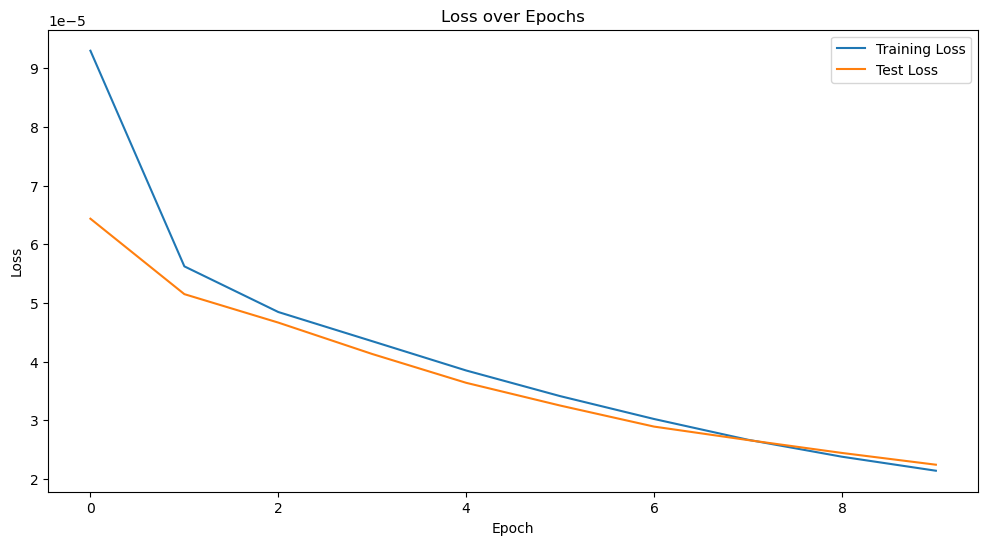

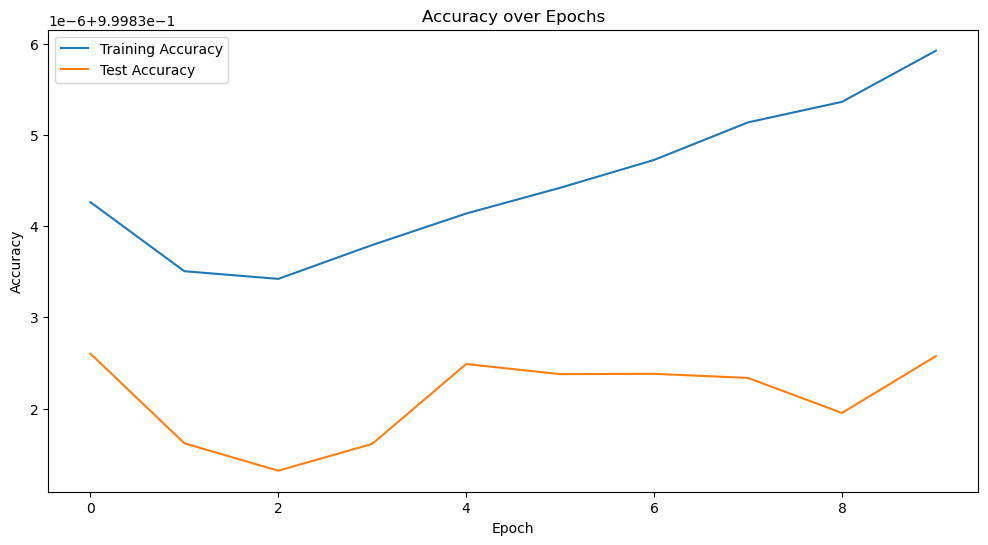

In [11]:
# Plot training and test loss
# Note: Something is odd with the training accuracy. It doesn't match the data from the model training. Look into later.

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

# Plot training and test accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

In [12]:
# Print the values of 'output' and its shape.
# Set 'file_index' for printing spectrograms.
# The red code was used for saved STFTs. Now using inline. Can delete.

#file_index = 2562  # this is the variable that you can change. It represents the 'nth' audio slice 11810
file_index = 9941  # this is the variable that you can change. It represents the 'nth' audio slice 11810


x_slice_100 = dataset[file_index][0].unsqueeze(0).to(device)

# Pass the input tensor through the model
output = model(x_slice_100)

# Print the output shape and the output for verification of tensor shape
print("Output shape:", output.shape)
print("Output:", output)

Output shape: torch.Size([1, 127, 832])
Output: tensor([[[-1.4900e-03,  1.8513e-03,  1.9317e-03,  ..., -7.2540e-04,
          -7.1812e-04,  3.0441e-04],
         [-7.9522e-04, -1.8506e-03, -1.0054e-03,  ..., -1.2251e-03,
          -1.9553e-04,  1.7070e-05],
         [ 4.2192e-04,  3.8416e-05, -3.1628e-06,  ...,  7.6145e-05,
           3.1544e-04, -1.9231e-04],
         ...,
         [ 3.3311e-03,  1.3191e-03, -1.4833e-04,  ...,  6.8409e-05,
          -1.8780e-04,  1.5035e-04],
         [ 4.4385e-03,  1.2221e-03,  7.5740e-04,  ..., -2.4593e-04,
           1.0472e-04, -3.1364e-04],
         [ 2.8390e-03, -1.5875e-03,  2.3455e-03,  ...,  3.4684e-04,
          -3.0411e-04, -2.8643e-04]]], device='cuda:0',
       grad_fn=<ConvolutionBackward0>)


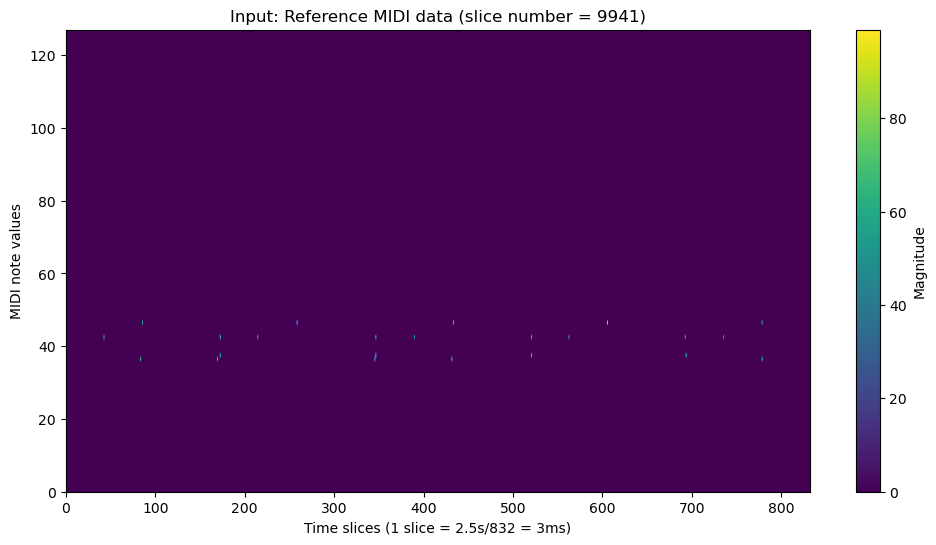

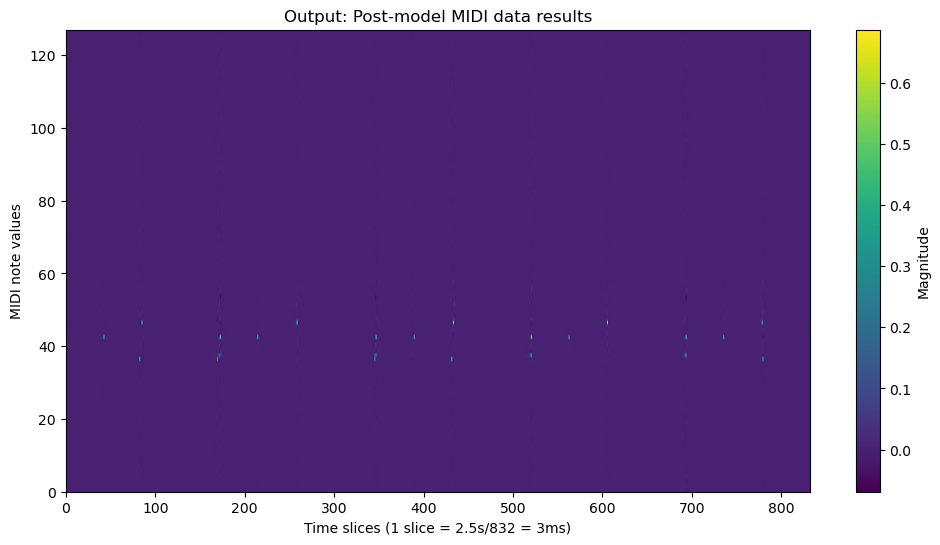

In [18]:
# Plots the output of the STFT that was opened from disk. Tests the model.
# Compares the Input MIDI file (which generated the audio) to the resulting output MIDI file.
# array_path = "D:/Python/common/midi/STFT/stft_spectrogram_0.npy"  
# Change the slice number in the previous code window.

stft_check = output.detach().squeeze(0).cpu().numpy()

trunc_time = 2.5 * (832/862)

import matplotlib.pyplot as plt

#file_path = r"D:\Python\common\midi\MIDI\processed_midi_{0}.npy".format(file_index)
#spectrogram = np.load(file_path)
spectrogram = list_of_processed_midi[file_index]

# Plot Input File
plt.figure(figsize=(12, 6))
plt.imshow(spectrogram, origin='lower', aspect='auto', cmap='viridis', extent=[0, 832, 0, 127])
plt.colorbar(label='Magnitude')
plt.xlabel('Time slices (1 slice = 2.5s/832 = 3ms)')
plt.ylabel('MIDI note values')
plt.title(f'Input: Reference MIDI data (slice number = {file_index})')

plt.show()

# Plot Output File
plt.figure(figsize=(12, 6))
plt.imshow(stft_check, origin='lower', aspect='auto', cmap='viridis', extent=[0, 832, 0, 127])
plt.colorbar(label='Magnitude')
plt.xlabel('Time slices (1 slice = 2.5s/832 = 3ms)')
plt.ylabel('MIDI note values')
plt.title('Output: Post-model MIDI data results')
plt.show()



In [19]:
import numpy as np

# file_index is set in the code before the graphing.
# these are the actual values of the midi file that was used to generate the wav file.

spectrogram = list_of_processed_midi[file_index]

non_zero_values = []

# Iterate over the spectrogram
for i in range(spectrogram.shape[0]):
    for j in range(spectrogram.shape[1]):
        # If the value is non-zero
        if spectrogram[i][j] != 0:
            non_zero_values.append((i, j, spectrogram[i][j]))

# Sort the list by the y values (j indices)
non_zero_values.sort(key=lambda x: x[1])

# Print the sorted list
for val in non_zero_values:
    print(f"x: {val[0]}, y: {val[1]}, value: {int(val[2])}")


x: 42, y: 42, value: 69
x: 36, y: 83, value: 82
x: 46, y: 85, value: 69
x: 36, y: 169, value: 80
x: 37, y: 172, value: 83
x: 42, y: 172, value: 82
x: 42, y: 214, value: 71
x: 46, y: 258, value: 87
x: 36, y: 345, value: 76
x: 37, y: 346, value: 87
x: 42, y: 346, value: 78
x: 42, y: 389, value: 65
x: 36, y: 431, value: 88
x: 46, y: 433, value: 87
x: 37, y: 520, value: 84
x: 42, y: 520, value: 79
x: 42, y: 562, value: 65
x: 46, y: 605, value: 99
x: 42, y: 692, value: 76
x: 37, y: 693, value: 83
x: 42, y: 735, value: 64
x: 36, y: 778, value: 80
x: 46, y: 778, value: 70


In [20]:
# This lists the values of the output midi file. There will be noise, so a threshold in necessary.
# Won't be perfect due to limited training and source material, but timing will be very good.
# Get the indices where vel > threshold

# Set threshold to eliminate noise
threshold = 0.2

indices = np.argwhere(stft_check > threshold)

# Sort the indices by the y values (second column)
sorted_indices = indices[indices[:, 1].argsort()]

# Print the x, y, and vel values
for idx in sorted_indices:
    x, y = idx
    vel = stft_check[x, y]
    vel *= 127
    print(f"x: {x}, y: {y}, vel: {int(vel)}")


x: 42, y: 42, vel: 71
x: 36, y: 82, vel: 71
x: 46, y: 84, vel: 34
x: 46, y: 85, vel: 43
x: 36, y: 169, vel: 56
x: 42, y: 172, vel: 87
x: 42, y: 214, vel: 75
x: 46, y: 258, vel: 84
x: 36, y: 345, vel: 62
x: 37, y: 346, vel: 28
x: 42, y: 346, vel: 41
x: 42, y: 347, vel: 45
x: 42, y: 389, vel: 60
x: 36, y: 431, vel: 81
x: 46, y: 433, vel: 84
x: 37, y: 519, vel: 27
x: 37, y: 520, vel: 47
x: 42, y: 520, vel: 79
x: 42, y: 562, vel: 70
x: 46, y: 605, vel: 83
x: 37, y: 692, vel: 28
x: 42, y: 693, vel: 85
x: 37, y: 693, vel: 42
x: 42, y: 735, vel: 66
x: 46, y: 778, vel: 57
x: 36, y: 779, vel: 60


In [ ]:
"""
# Test the DataLoader. Not needed for modeling.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Get the first batch of data
first_batch = next(iter(dataloader))

# Extract the X and Y data
x_data, y_data = first_batch

# Move the data to the GPU (if available)
x_data = x_data.to(device)
y_data = y_data.to(device)

# Print the shape of the X and Y data
print("X shape:", x_data.shape)
print("Y shape:", y_data.shape)

"""

num_samples:  110250


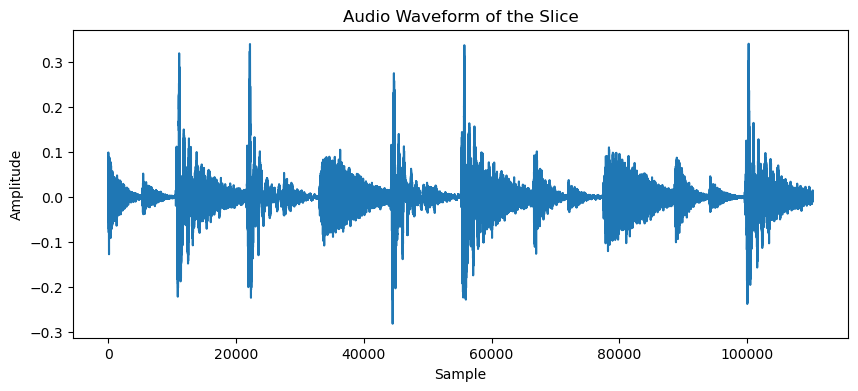

STFT kernels created, time used = 0.0711 seconds
stft_output.shape:  (1025, 832)


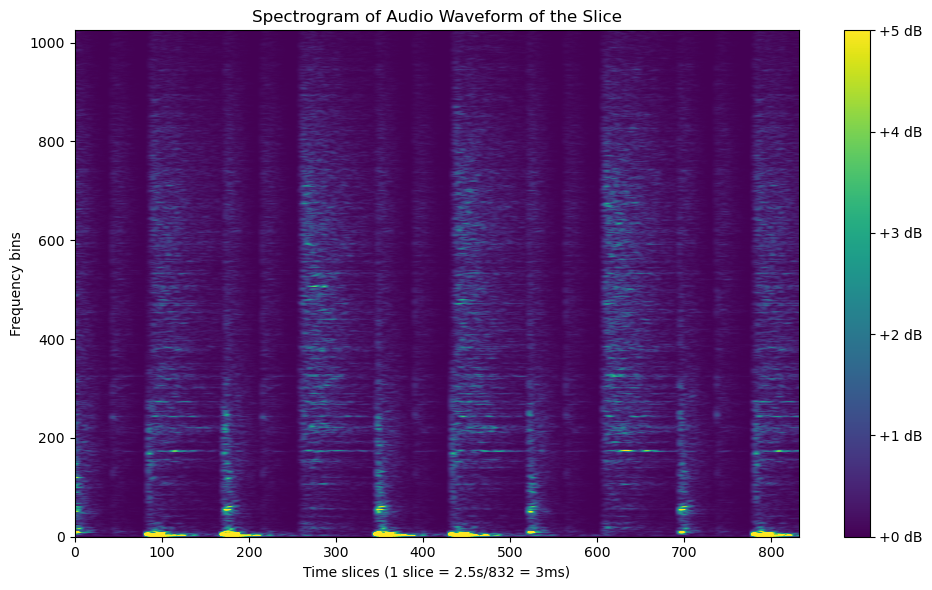

In [21]:
import librosa
import matplotlib.pyplot as plt
from nnAudio.Spectrogram import STFT
import torch

# The purpose of this code is to print the audio wav file and STFT of the corresponding audio slice.
# The audio, STFT, and Input/Output spectrograms should (and do) align in time.


# Load the full audio file
audio_path = r"D:\Python\common\GM\reaper_GM_audio_1.wav"
waveform, sample_rate = librosa.load(audio_path, sr=None)  # Load with the original sample rate

# Calculate the number of samples per 2.5-second slice
slice_length = int(2.5 * sample_rate)

# Choose which slice to plot (e.g., the nth slice)
n = file_index  # Replace with the desired slice number
start_sample = n * slice_length
end_sample = start_sample + slice_length

# Check if the selected slice is within the waveform length
if end_sample <= len(waveform):
    slice_waveform = waveform[start_sample:end_sample]
else:
    print("The selected slice number exceeds the length of the audio.")
    slice_waveform = waveform[-slice_length:]  # Use the last slice if the nth slice is not available
    
    
# Extract the slice
end_sample_truncate = (end_sample - 30)
slice_waveform_truncate = slice_waveform[start_sample:end_sample_truncate]
print ('num_samples: ', len(slice_waveform))

# Plot the waveform of the slice
plt.figure(figsize=(10, 4))
plt.plot(slice_waveform)
plt.title('Audio Waveform of the Slice')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

# Convert the audio to a tensor and add an extra dimension for the batch size
audio_tensor = torch.tensor(slice_waveform).unsqueeze(0)

# Create the STFT layer
stft_layer = STFT(n_fft=2048, hop_length=128, win_length=2048, trainable=False, window='hann', output_format='Magnitude')

# Apply the STFT to the audio
stft_output = stft_layer(audio_tensor)

# Truncate the data to 832 points in the x-direction
truncated_data = stft_output[0, :, :832].detach().numpy()

print("stft_output.shape: ", truncated_data.shape)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(truncated_data, aspect='auto', origin='lower', vmin=0, vmax=5, extent=[0, 832, 0, 1025])
plt.title('Spectrogram of Audio Waveform of the Slice')
plt.xlabel('Time slices (1 slice = 2.5s/832 = 3ms)')
plt.ylabel('Frequency bins')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [24]:
import sys

print("Python version:")
print(sys.version)

print("\nPython info:")
print(sys.version_info)

print("\nJupyter Notebook version:")
import notebook
print(notebook.__version__)

print("\nIPython version:")
import IPython
print(IPython.__version__)

print("\nNumPy version:")
import numpy as np
print(np.__version__)

print("\nPandas version:")
import pandas as pd
print(pd.__version__)

print("\nMatplotlib version:")
import matplotlib
print(matplotlib.__version__)

print("\nScikit-Learn version:")
import sklearn
print(sklearn.__version__)

print("\nPyTorch version:")
import torch
print(torch.__version__)

print("\nscipy version:")
import scipy
print(scipy.__version__)

print("\njoblib version:")
import joblib
print(joblib.__version__)

print("\nlibrosa version:")
import librosa
print(librosa.__version__)

print("\nnnAudioversion:")
import nnAudio
print(nnAudio.__version__)

import torch
cuda_version = torch.version.cuda if torch.cuda.is_available() else "No CUDA support"
print(f"\nCUDA Version: {cuda_version}")

Python version: 3.10.9 | packaged by conda-forge | (main, Jan 11 2023, 15:15:40) [MSC v.1916 64 bit (AMD64)]
3.10.9 | packaged by conda-forge | (main, Jan 11 2023, 15:15:40) [MSC v.1916 64 bit (AMD64)]

Python info:
sys.version_info(major=3, minor=10, micro=9, releaselevel='final', serial=0)

Jupyter Notebook version:
6.5.2

IPython version:
8.10.0

NumPy version:
1.24.3

Pandas version:
1.5.3

Matplotlib version:
3.6.2

Scikit-Learn version:
1.2.2

PyTorch version:
1.12.1

scipy version:
1.10.1

joblib version:
1.1.1

librosa version:
0.9.2

nnAudioversion:
0.3.2

CUDA Version: 11.3
